In [1]:
import os 
import torch 
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the input (which contain the after and before image)
folder_path = "../../bench"
print(os.path.realpath(folder_path))

C:\Users\ADMIN\workspace\GitHub\BKAI-Demo-Motorbike-PyQT\bench


In [3]:
# Change the directory to the folder path
os.chdir(os.path.dirname(folder_path))
print(os.getcwd())

c:\Users\ADMIN\workspace\GitHub\BKAI-Demo-Motorbike-PyQT


In [4]:
from src.notebook.detector import Detector
from src.models.Models import Models

# Call the detector and classifier
detector = Detector(weights="yolov9c.pt")
resnet_classifier = Models(model="resnet18", num_classes=3)
vit_classifier = Models(model="vit", num_classes=3)

# Load the weights
resnet_classifier.load_weight("weight/classify/resnet18.ckpt")
vit_classifier.load_weight("weight/classify/vit.ckpt")

c:\Users\ADMIN\.conda\envs\motor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-01 23:55:24 [    INFO] Weight has been loaded from weight/classify/resnet18.ckpt (src.models - :\Users\ADMIN\workspace\GitHub\BKAI-Demo-Motorbike-PyQT\:\Users\ADMIN\workspace\GitHub\BKAI-Demo-Motorbike-PyQT\src\models\Models.py:44)
2024-05-01 23:55:24 [    INFO] Weight has been loaded from weight/classify/vit.ckpt (src.models - :\Users\ADMIN\workspace\GitHub\BKAI-Demo-Motorbike-PyQT\:\Users\ADMIN\workspace\GitHub\BKAI-Demo-Motorbike-PyQT\src\models\Models.py:44)


In [5]:
# Utils function
import cv2
import uuid

def draw(
    frame: np.ndarray, 
    bboxes: list, 
    scores: list, 
    class_ids: list
) -> np.ndarray:
    for bbox, score, class_id in zip(bboxes, scores, class_ids):
        x1, y1, x2, y2 = map(int, bbox)
        color = (0, 255, 0)  # Green color for bounding box
        frame = cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        label = f"Class: {int(class_id)}, Score: {score:.2f}"
        frame = cv2.putText(
            frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 4
        )

    return frame

def classify(bboxes, img: np.ndarray, classifier: Models) -> list:
        img = Image.fromarray(img)

        class_ids = []
        for bbox in bboxes:
            x1, y1, x2, y2 = map(int, bbox)

            cropped_img = img.crop((x1, y1, x2, y2))
            class_id = classifier.infer(cropped_img)
            cropped_img.save(f".temp/cropped_img_{str(uuid.uuid4())[:4]}_pred_{class_id}.jpg")
            class_ids.append(class_id)

        return class_ids

In [13]:
from PIL import Image
from typing import List, Dict

def infer(img_path: str, detect_conf: float = 0.3, classifiers: List[Models] = []) -> Dict[str, np.ndarray]:
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detection phase
    bboxes, scores = detector.detect(frame=img, conf=detect_conf)
    
    # Classify the detected object
    output = {}
    
    for classifier in classifiers:
        name = classifier.name
        class_ids = classify(bboxes, img, classifier)
        
        # Copy the img 
        img_drawed = img.copy()
        
        img_drawed: np.ndarray = draw(img_drawed, bboxes, scores, class_ids)
        output[name] = img_drawed
    
    return output

In [7]:
# Infer the image
def process(img_name: str, parent_dir: str, detect_conf: float = 0.3) -> None:
    before_img_path = f"{parent_dir}/{img_name}.jpg"
    after_img_path = f"{parent_dir}/{img_name}_after.jpg"

    output_before = {
        "Original": cv2.cvtColor(cv2.imread(before_img_path), cv2.COLOR_BGR2RGB),
    }
    output_after = {
        "Original": cv2.cvtColor(cv2.imread(after_img_path), cv2.COLOR_BGR2RGB),
    }

    output_before.update(infer(before_img_path, detect_conf=detect_conf, classifiers=[resnet_classifier, vit_classifier]))
    output_after.update(infer(after_img_path, detect_conf=detect_conf, classifiers=[resnet_classifier, vit_classifier]))

    # Plot the image
    fig, ax = plt.subplots(2, 3, figsize=(20, 8))

    for i, (key, value) in enumerate(output_before.items()):
        ax[0, i].imshow(value)
        ax[0, i].set_title(f"{key} - Before")
        # ax[0, i].axis("off")
        
    for i, (key, value) in enumerate(output_after.items()):
        ax[1, i].imshow(value)
        ax[1, i].set_title(f"{key} - After")
        # ax[1, i].axis("off")
        
    plt.tight_layout()

    plt.savefig(f"output/output_{img_name}.jpg")
    print(f"Image saved as output_{img_name}.jpg")

Image saved as output_image1.jpg
Image saved as output_image2.jpg
Image saved as output_image3.jpg


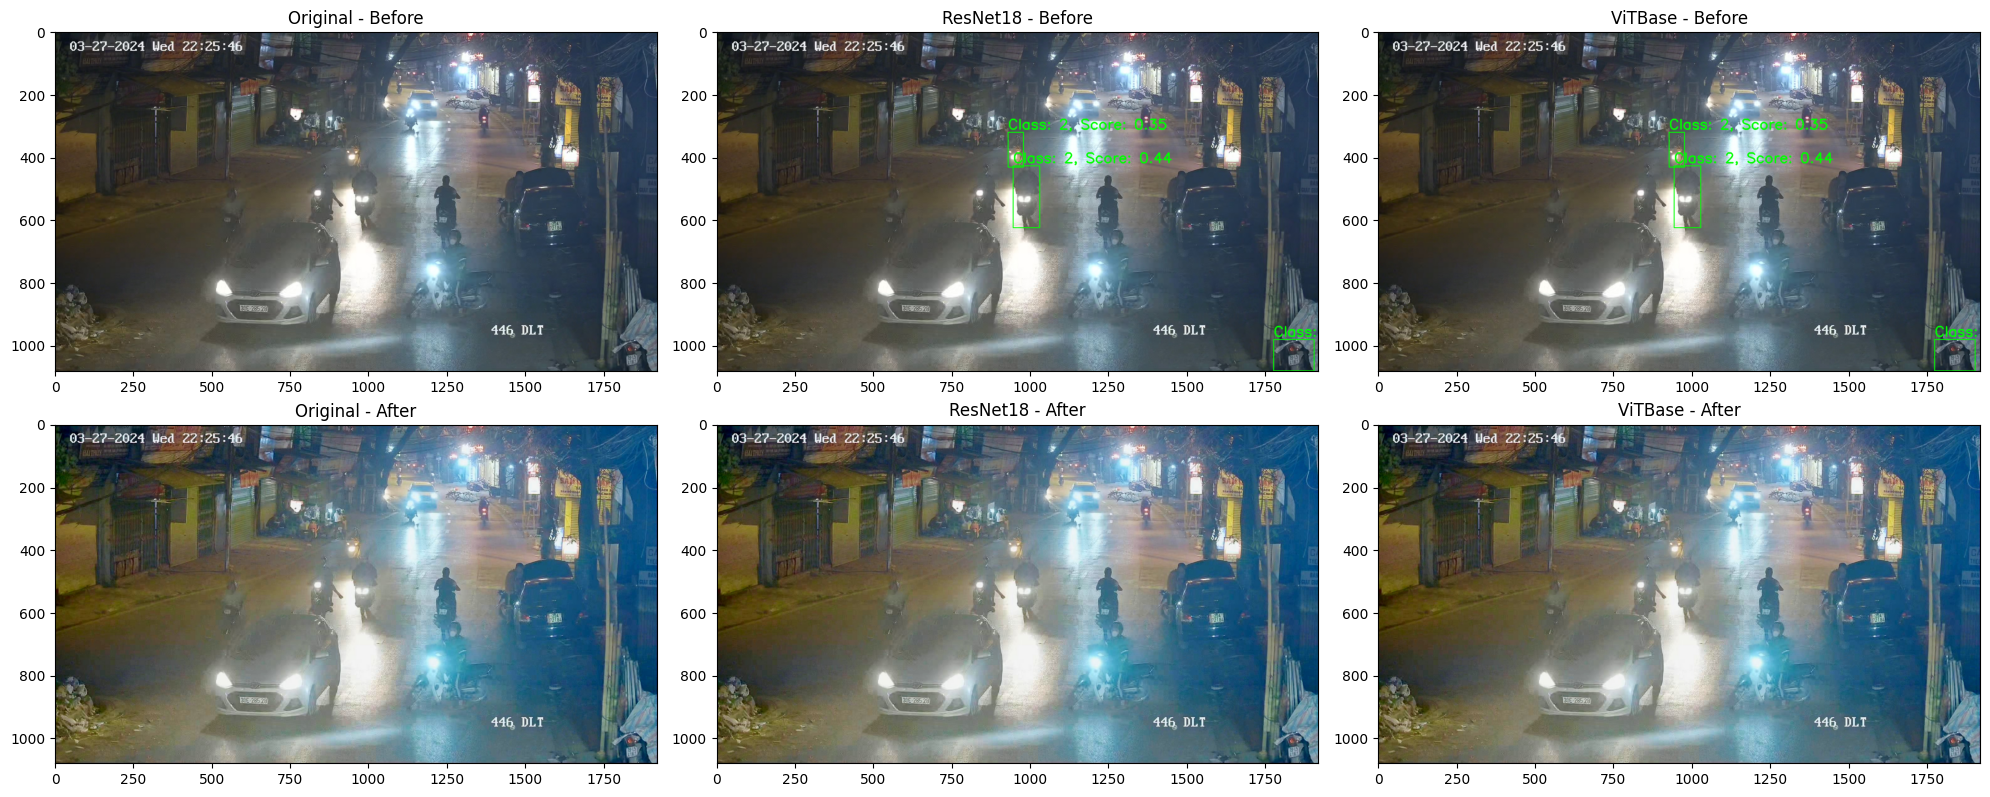

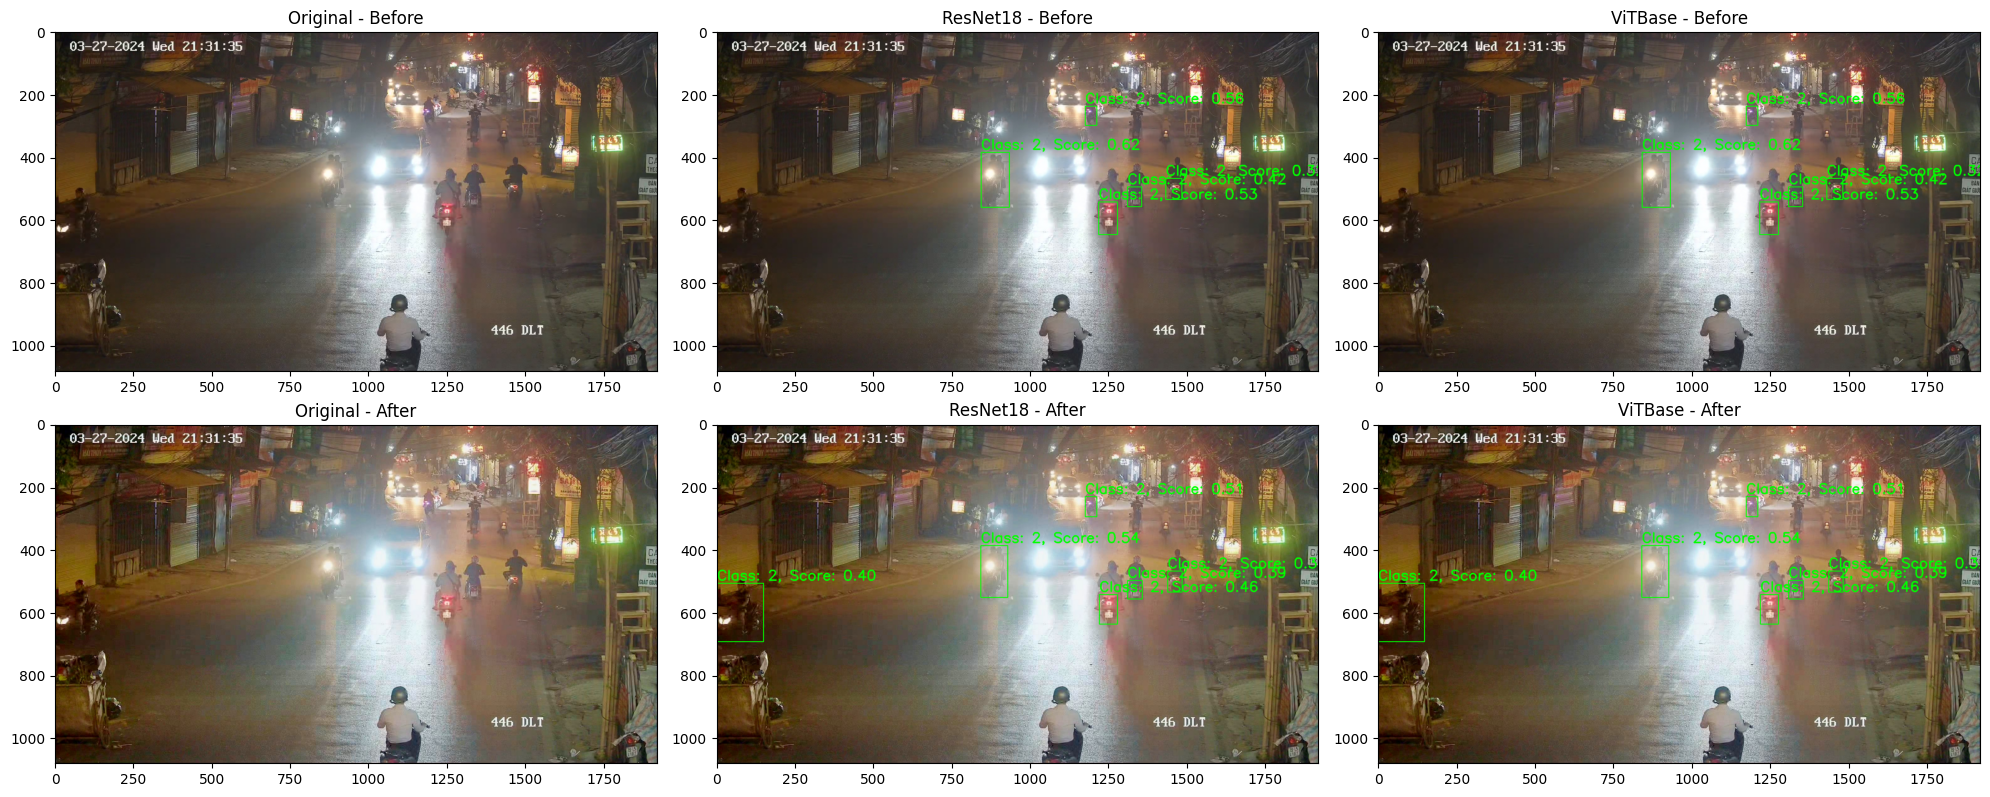

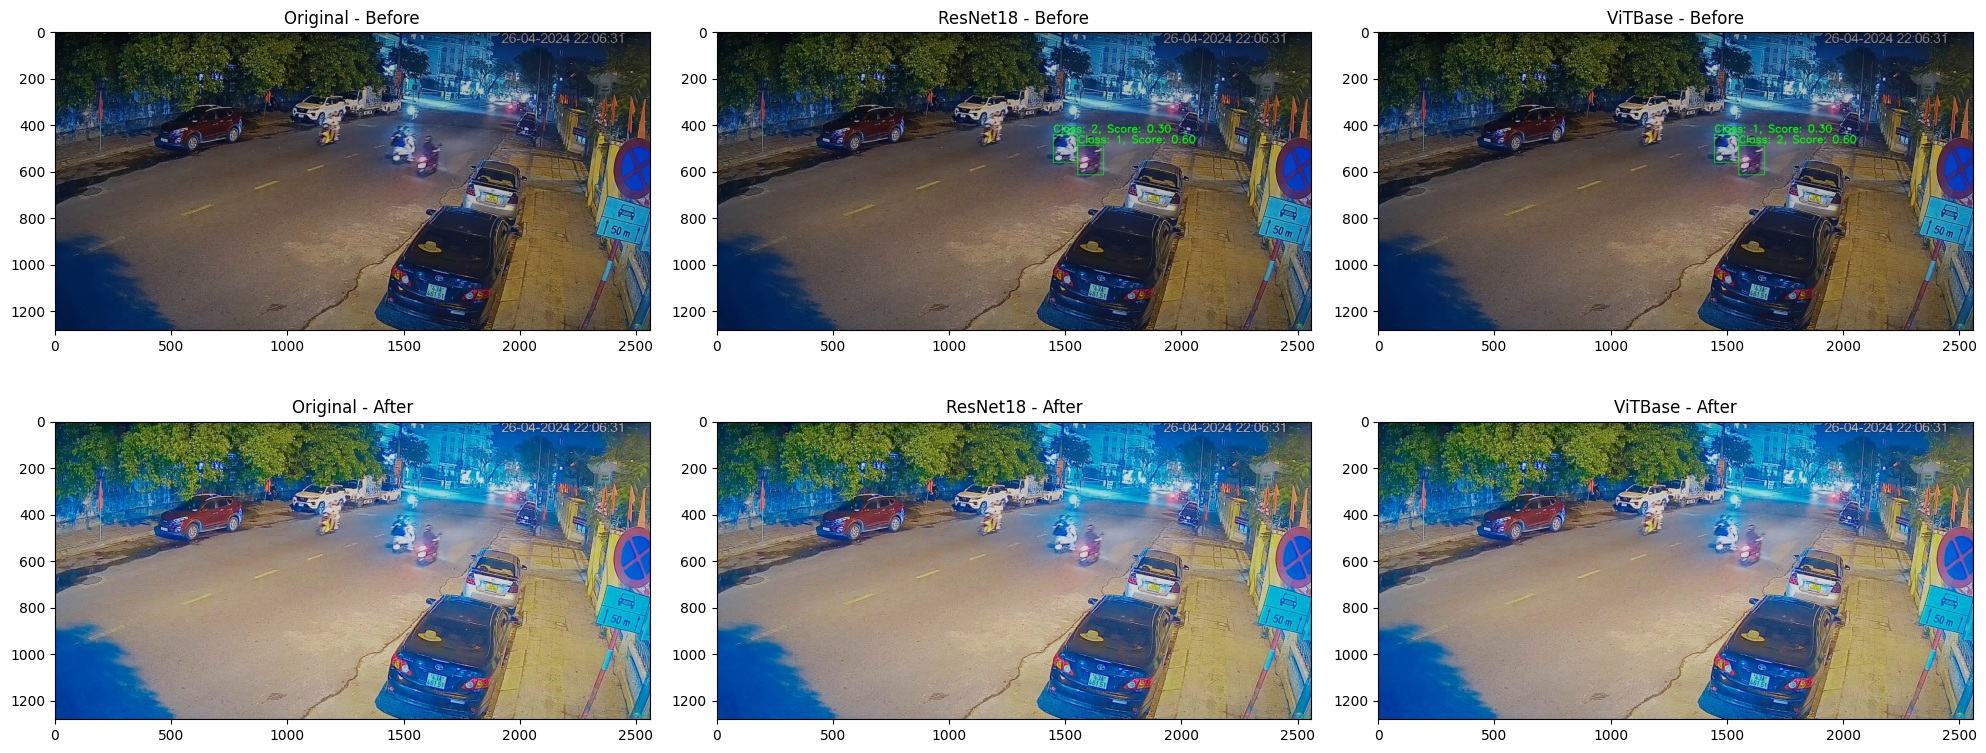

In [14]:
for file_name in os.listdir(r"bench"):
    if file_name.find("after") == -1:
        process(file_name.split(".")[0], r"bench")